# GAN: Generative Adversarial Network

Red GAN que utiliza espectrogramas para entrenar y luego el algoritmo de Griffin-Lim para reconstruir la fase y volver al dominio temporal.

Basado en la implementación de https://github.com/naotokui/SpecGAN
    SpecGAN - generate audio with adversarial training
    an unofficial implementation of SpecGAN, a Generative Adversarial Network model for generating spectrogram images, proposed in: Donahue, C., McAuley, J., & Puckette, M. (2018). Synthesizing Audio with Generative Adversarial Networks.http://arxiv.org/abs/1802.04208

# Dependencias

    sudo apt install python2
    sudo python2 -m pip install ipykernel
    sudo python2 -m ipykernel install --user
    sudo python2 -m pip install keras tensorflow librosa soundfile pillow

In [ ]:
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation, UpSampling2D, Conv2D
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from keras import backend as K
from functools import partial
import tensorflow as tf

In [ ]:
import sys
sys.path.append("..") 
from utils import audio_tools as audio

# Armado del dataset

Búsqueda por el tag. Samples de 5 segundos máximo. Generación de al menos 2 categorias, ejemplo: "voz" y "bateria"

# Pre-procesamiento

Generar un archivo con los espectrogramas normalizados de los archivos de entrenamiento e información sobre la categorias.

    $ python2 preprocess_audio.py -i ~/Datasets/RedPanal/GAN -o ~/Datasets/RedPanal/GAN/training_data.npz

    Categories: ['voz', 'bateria']
    # of categories: 2
    # of files: 99

    generate normalized spectrogram images... 

    save data into  ~/Datasets/RedPanal/GAN/training_data.npz
    Done

# Entrenamiento

200 epochs. La cantidad de veces o pasadas que voy a entrenar con todo el dataset.

    python2 specgan_categorical.py -i ~/Datasets/RedPanal/GAN/training_data.npz -o ./checkpoints -e 200

In [3]:
# Model1: en base a 'voz' (mbaraj) y bateria (dirty drum) (200 epochs)
# Model2: en base a 'voz' (mbaraj) y voz 'al norte' (100 epochs)
# Model3: 300 epochs
DATASET_PATH = "/home/hordia/Datasets/RedPanal/GAN/model3/" # linux

# training data generated with preprocess_audio.py
DATAPATH = DATASET_PATH + "training_data.npz"

# trained model paths for generator and discriminator

G_WEIGHT_PATH = DATASET_PATH + "pretrained_models/generator_epoch.h5"
D_WEIGHT_PATH = DATASET_PATH + "pretrained_models/discriminator_epoch.h5"

In [4]:
# category info
CATEGORIES = np.load(DATAPATH)["category_names"]
nb_categories = len(CATEGORIES)

# for denomalizing mel_spectrogram
mel_means = np.load(DATAPATH)["mean"]
mel_stds = np.load(DATAPATH)["std"]

In [5]:
def make_generator():
    D = 64 # model size

    model = Sequential()
    model.add(Dense(256 * D, input_dim=100))
    model.add(Reshape((4, 4, 16 * D)))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(8 * D, (5, 5), padding='same'))
    #model.add(Conv2DTranspose(8*D, (5, 5), strides=(2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(4 * D, (5, 5), padding='same'))
    #model.add(Conv2DTranspose(4*D, (5, 5), strides=(2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(2 * D, (5, 5), padding='same'))
    #model.add(Conv2DTranspose(2*D, (5, 5), strides=(2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(D, (5, 5), padding='same'))
    model.add(UpSampling2D(size=(2, 2)))
    #model.add(Conv2DTranspose(D, (5, 5), strides=(2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    #model.add(Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same'))

    model.add(Activation('tanh'))

    return model

def make_discriminator(nb_categories):
    D = 64 # model size

    input_data = Input(shape=(128, 128, 1))
    x = Conv2D(D, (5, 5), strides=(2,2), padding='same')(input_data)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(D * 2, (5, 5), strides=(2,2), kernel_initializer='he_normal',padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(D * 4, (5, 5), strides=(2,2), kernel_initializer='he_normal',padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(D * 8, (5, 5), strides=(2,2), kernel_initializer='he_normal',padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(D * 16, (5, 5), strides=(2,2), kernel_initializer='he_normal', padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    real_fake = Dense(1, kernel_initializer='he_normal', name='real_fake')(x) # no activation for wasserstein_loss
    categories = Dense(nb_categories, kernel_initializer='he_normal', name='categories', activation='softmax')(x)

    model = Model(input_data, [real_fake, categories])

    return model


In [6]:
nb_categories

2

In [7]:
generator = make_generator()
discriminator = make_discriminator(nb_categories)

# load weights
generator.load_weights(G_WEIGHT_PATH)
discriminator.load_weights(D_WEIGHT_PATH)

In [8]:
# check if the discriminator thinks the generated sound as real sound
#CONFIDENCE_THRESH = 0.80

In [13]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
reload(audio)
import IPython
from IPython.display import Audio
from IPython.display import clear_output

# check if the discriminator thinks the generated sound as real sound
CONFIDENCE_THRESH = 0.80

def denormalize(norm_s):
    assert norm_s.shape[0] == mel_means.shape[0]
    Y = (norm_s * (3.0 * mel_stds)) + mel_means
    return Y

def save_audio(y, path, category=None, stereo=False):
    _s = np.squeeze(y)
    
    if stereo:
        assert _s.shape[0] == 2
        channels = []
        for s in _s:
            s = denormalize(s)
            w = audio.inv_melspectrogram(s)
            channels.append(w)
        w = np.vstack(channels)
        w = np.transpose(w)
        audio.save_wav(w, path)    
    else:
        s = denormalize(_s)
        w = audio.inv_melspectrogram(s)
        audio.save_wav(w, path)
    
def show_spec(S, display=False):    
    if S.shape[0] == 2:
        S = S[0]
    S = np.squeeze(S)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S)
    plt.show()
    
    if display:
        path = "/tmp/test.wav"
        save_audio(S, path)
        IPython.display.display(Audio(path))

def classify_drums(w, thresh=CONFIDENCE_THRESH):
    w = np.squeeze(w)
    w = w[np.newaxis, :, :, np.newaxis]
    r, p = discriminator.predict([w])
    print("r: ",float(r))
    if 1:
    #if float(r) > thresh:
        return np.argmax(p)
    else:
        return -1

### Generar un nuevo sonido

('r: ', -3.4495861530303955)
('Clasif: ', 0)
voz


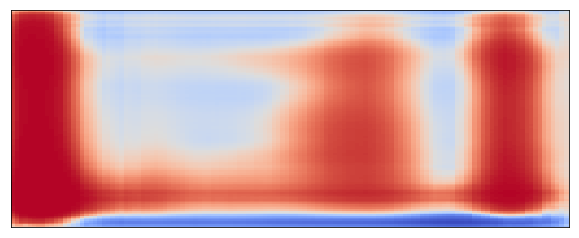

In [14]:
#WARNING: using a fixed CONFIDENCE_THRESH

def generate_random_sound(max_try= 10):

    for i in range(max_try):
        seed = np.random.rand(1, 100)
        w =   generator.predict(seed)
        #id_category = classify_drums(w[0])
        id_category = classify_drums(w[0],thresh=.9)
        print("Clasif: ", id_category)
        category =  CATEGORIES[id_category]
        if  id_category >= 0:
            save_audio(w, "./drums_%s.wav" % category, category=category)
            print category
            show_spec(w, True)
            break

generate_random_sound()

('r: ', -3.3952643871307373)
('Clasif: ', 0)
voz


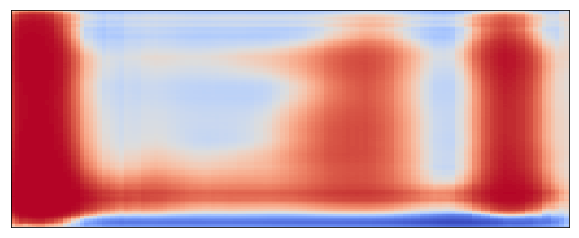

In [15]:
generate_random_sound()

('r: ', -3.4716641902923584)
('Clasif: ', 0)
voz


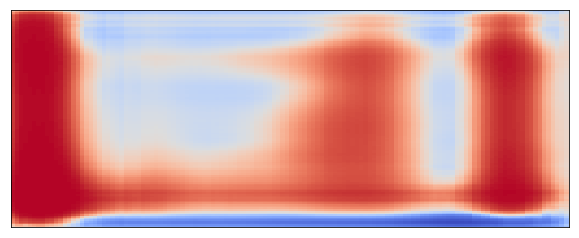

In [16]:
generate_random_sound()